# 0. Install Dependencies and Bring in Data

In [ ]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [6]:
MAX_FEATURES = 2500 # number of words in the vocab

In [7]:
#We pass the following into the TextVectorization layer:
#Maximum number of words in the vocab, The maximum length of a sentence, Mapping each word into integers
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=200,
                               output_mode='int')
#vectorizer('Hello world, life is great')[:5]

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-11 09:19:57.851233: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-11 09:19:57.851981: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
#This teachers the vectorizer all the words that are in the vocabulary
vectorizer.adapt(X.values)

2023-01-11 09:20:00.642087: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-11 09:20:00.728948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [9]:
vectorized_text = vectorizer(X.values)

In [10]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [11]:
dataset.as_numpy_iterator().next()

(array([[  13,   21,    1, ...,    0,    0,    0],
        [   8,  253,   10, ...,    0,    0,    0],
        [   1,  491,    1, ...,    0,    0,    0],
        ...,
        [1211,    1, 2075, ...,    0,    0,    0],
        [   8,   19,    1, ...,    0,    0,    0],
        [   1,    1,  714, ...,    0,    0,    0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [12]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [56]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [57]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          80032     
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [60]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 1001s 143ms/step - loss: 0.0511 - val_loss: 0.0506
Epoch 2/5
6981/6981 [==============================] - 976s 140ms/step - loss: 0.0497 - val_loss: 0.0463
Epoch 3/5
6981/6981 [==============================] - 988s 142ms/step - loss: 0.0486 - val_loss: 0.0450
Epoch 4/5
6981/6981 [==============================] - 1005s 144ms/step - loss: 0.0473 - val_loss: 0.0454
Epoch 5/5
6981/6981 [==============================] - 987s 141ms/step - loss: 0.0457 - val_loss: 0.0455


In [61]:
history.history

{'loss': [0.05113796889781952,
  0.049661051481962204,
  0.0485604964196682,
  0.04728084057569504,
  0.04572437331080437],
 'val_loss': [0.050618723034858704,
  0.04629013314843178,
  0.04496488720178604,
  0.04539265111088753,
  0.04551185294985771]}

In [62]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

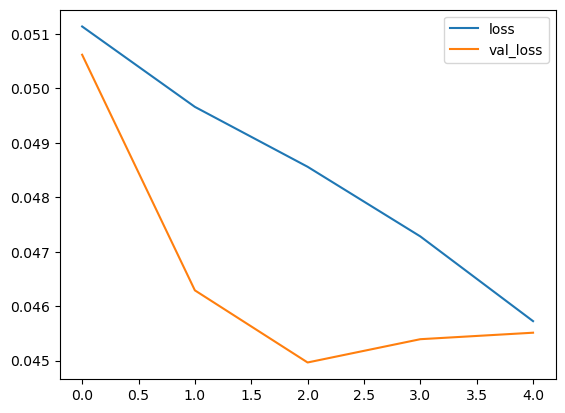

In [63]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [64]:
input_text = vectorizer('I hate you')

In [65]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [66]:
model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 325ms/step


array([[8.4298545e-01, 6.2110886e-04, 5.3694338e-02, 5.3829857e-04,
        3.2531634e-01, 9.4840731e-03]], dtype=float32)

In [67]:
batch = test.as_numpy_iterator().next()

In [68]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [69]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 1s 848ms/step


array([[1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0]])

In [70]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 90ms/step


In [71]:
(res > 0.5).astype(int) 

array([[1, 0, 0, 0, 0, 0]])

In [72]:
res.shape

(1, 6)

# 4. Evaluate Model

In [73]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [74]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [75]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 86ms/step


In [76]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8249918222427368, Recall:0.7220155000686646, Accuracy:0.476429283618927


# 5. Test and Gradio

In [ ]:
!pip install gradio jinja2

In [77]:
import tensorflow as tf
import gradio as gr

In [78]:
model.save('toxicity.h5')

In [79]:
model = tf.keras.models.load_model('toxicity.h5')

In [80]:
input_str = vectorizer('Goodnight baby. Im soo tired rn!')

In [81]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [82]:
res = model.predict(np.expand_dims(input_str,0))

2023-01-11 12:17:02.797498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-11 12:17:02.981751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-11 12:17:03.002468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


In [83]:
res

array([[0.16312365, 0.00079282, 0.05437826, 0.00106959, 0.04448799,
        0.00429223]], dtype=float32)

In [84]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    return text


In [85]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                         outputs='text',
                         title="Comment Toxicity Detector")

/Users/ezra/opt/miniconda3/envs/env_ai_project/lib/python3.9/site-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/ezra/opt/miniconda3/envs/env_ai_project/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/Users/ezra/opt/miniconda3/envs/env_ai_project/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [86]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7870
Running on public URL: https://bcd9ceb4-c140-4faa.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 107ms/step
